In [95]:
import pandas as pd
from amplpy import AMPL , add_to_path
import matplotlib.pyplot as plt

In [113]:
# Load cleaned adjusted close prices for 5 10 15 20
df_5 = pd.read_csv('../data/sp100_selected_data_5.csv', index_col=0, parse_dates=True)
df_10 = pd.read_csv('../data/sp100_selected_data_10.csv', index_col=0, parse_dates=True)
df_15 = pd.read_csv('../data/sp100_selected_data_15.csv', index_col=0, parse_dates=True)
df_20 = pd.read_csv('../data/sp100_selected_data_20.csv', index_col=0, parse_dates=True)

df = df_20
# Ensure all values are numeric
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(method='ffill').fillna(method='bfill')


/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_4199/1715319723.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_5 = pd.read_csv('../data/sp100_selected_data_5.csv', index_col=0, parse_dates=True)
/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_4199/1715319723.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_10 = pd.read_csv('../data/sp100_selected_data_10.csv', index_col=0, parse_dates=True)
/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_4199/1715319723.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_15 = pd.read_csv('..

In [114]:
def strip_suffix(name):
    return name.split('.')[0].strip()

df.columns = [strip_suffix(col) for col in df.columns]
df = df.loc[:, ~df.columns.duplicated()]

In [115]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod()


In [116]:
# Define q = number of stocks to select
q = 20
# Step 1: Drop ^OEX before correlation to avoid selecting it
correlations = cumulative_returns.drop(columns='^OEX').corrwith(cumulative_returns['^OEX'])

# Step 2: Get top 10 real stocks
top_q_stocks = correlations.sort_values(ascending=False).head(q).index.tolist()

# Calculate target return based on these stocks only
target_value = daily_returns[top_q_stocks].mean().mean()

# Display selected stock tickers
top_q_stocks


['TSM',
 'WMT',
 'AAPL',
 'ORCL',
 'TSLA',
 'JPM',
 'NVDA',
 'NFLX',
 'AMZN',
 'IBM',
 'V',
 'GOOGL',
 'PG',
 'VZ',
 'UNH',
 'MSFT',
 'JNJ',
 'XOM',
 'QCOM',
 'WBA']

In [117]:
# Filter the daily returns for selected stocks and benchmark
returns_for_ampl = daily_returns[top_q_stocks + ['^OEX']]

# Show the shape and head of the data
returns_for_ampl.shape, returns_for_ampl.head()


((252, 21),
                  TSM       WMT      AAPL      ORCL      TSLA       JPM  \
 Ticker                                                                   
 Date        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2024-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2024-04-02  0.022507 -0.006798 -0.012326 -0.008205 -0.064824 -0.008000   
 2024-04-03 -0.012822 -0.008681 -0.001715 -0.002008 -0.004431  0.003276   
 2024-04-04  0.039111  0.002694  0.008887  0.026879  0.036886  0.006389   
 
                 NVDA      NFLX      AMZN       IBM  ...     GOOGL        PG  \
 Ticker                                              ...                       
 Date        0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
 2024-04-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
 2024-04-02 -0.020499  0.004934 -0.009514 -0.004526  ...  0.018648 -0.013228   
 2024-04-03  0.000407  0.002864  0.004635 -0.002855  ...  0.0

In [118]:
# Average daily return for each stock (can be scaled later)
avg_returns = returns_for_ampl.mean()

# Print average return of each selected stock and the benchmark
avg_returns

# Calculate an achievable target return: average of selected stocks (excluding OEX)
target = avg_returns[top_q_stocks].mean()
print(f"Recommended target_return for AMPL: {target:.6f}")



Recommended target_return for AMPL: 0.000663


In [120]:
print(f"target_return: {avg_returns['^OEX']:.6f}")

target_return: 0.000334


In [121]:
# Clean and deduplicate stock selection
def clean_name(name):
    return name.replace("^", "").replace(".", "").replace("-", "").replace(" ", "").upper()

# Use only real stocks, exclude ^OEX from correlation matrix
correlations = cumulative_returns.drop(columns='^OEX').corrwith(cumulative_returns['^OEX'])

top_q_stocks = correlations.sort_values(ascending=False).head(10).index.tolist()

# Remove duplicates and clean names
top_q_stocks = list(dict.fromkeys(top_q_stocks))
name_map = {stock: clean_name(stock) for stock in top_q_stocks}
top_q_stocks_clean = [name_map[stock] for stock in top_q_stocks]

# Calculate average returns for selected stocks
avg_returns_selected = daily_returns[top_q_stocks].mean()

# Clean return index
avg_returns_clean = avg_returns_selected.rename(index=name_map)

# Build .dat file content
stock_set = "set STOCKS := " + ' '.join(top_q_stocks_clean) + ";\n"

return_param = "param r :=\n"
for stock in top_q_stocks:
    clean = name_map[stock]
    return_param += f"    {clean} {avg_returns_selected[stock]:.6f}\n"
return_param += ";\n"

# Calculate target return as average of selected stocks
target_value = avg_returns_selected.mean()
target_line = f"param target_return := {target_value:.6f};\n"

# Save to file
ampl_dat = stock_set + "\n" + return_param + "\n" + target_line
with open('../optimization/index_data.dat', 'w') as f:
    f.write(ampl_dat)

print("✅ FINAL clean .dat file created with:\n")
print(ampl_dat)

✅ FINAL clean .dat file created with:

set STOCKS := TSM WMT AAPL ORCL TSLA JPM NVDA NFLX AMZN IBM;

param r :=
    TSM 0.001084
    WMT 0.001487
    AAPL 0.001104
    ORCL 0.000741
    TSLA 0.002306
    JPM 0.000910
    NVDA 0.001267
    NFLX 0.001854
    AMZN 0.000351
    IBM 0.001224
;

param target_return := 0.001233;



In [123]:
# Step 1: Add AMPL to system path (update path if needed)
add_to_path("/Applications/AMPL")
åå
# Step 2: Create AMPL instance
ampl = AMPL()
ampl.reset()

# Step 3: Load model and data
ampl.read("../optimization/index_model.mod")
ampl.read_data("../optimization/index_data.dat") 

# Step 4: Set solver and solve
ampl.set_option("solver", "minos")
ampl.solve()

# Step 5: Output results
print("✅ Tracking error:", amplåååååS.get_value("tracking_error"))

w = ampl.get_variable("w")
print("\n📊 Portfolio Weights:")
for key, var in w:
    print(f"{key:<6} = {var.value():.4f}")



MINOS 5.51: 

optimal solution found.
0 iterations, objective 2.2201e-08
Nonlin evals: obj = 3, grad = 2.
✅ Tracking error: 2.2201000000000015e-08

📊 Portfolio Weights:
AAPL   = 0.0000
AMZN   = 0.0000
IBM    = 0.0000
JPM    = 0.0000
NFLX   = 0.0000
NVDA   = 0.0000
ORCL   = 0.0000
TSLA   = 0.0000
TSM    = 1.0000
WMT    = 0.0000


✅ AMPL weights saved to: ../data/ampl_portfolio_weights.csv


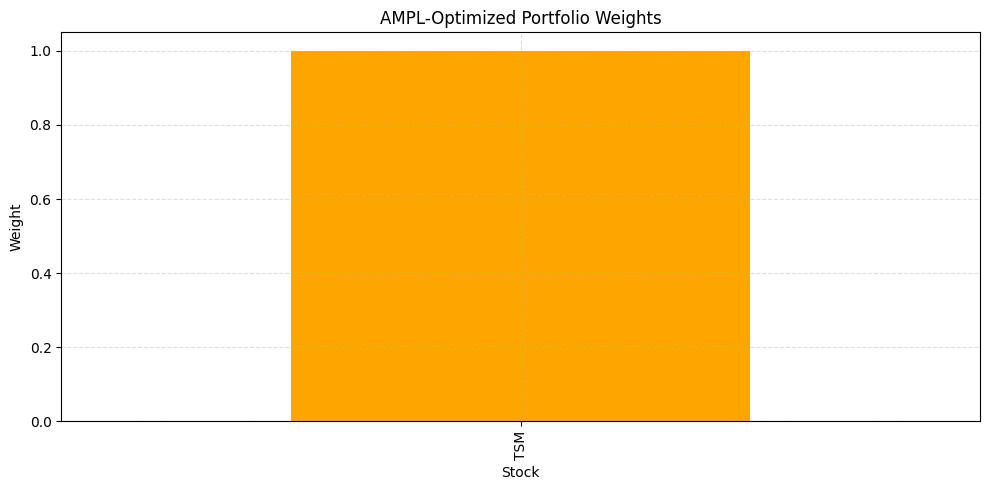

✅ AMPL weight chart saved to: ../data/ampl_portfolio_weights.png


In [124]:
# Get weights from AMPL solution
ampl_weights = {key: var.value() for key, var in w}
ampl_weights = pd.Series(ampl_weights)
ampl_weights = ampl_weights[ampl_weights > 0]  # Show only non-zero weights


# Save to CSV for evaluation
ampl_weights.to_csv("../data/ampl_portfolio_weights.csv", header=["Weight"])

print("✅ AMPL weights saved to: ../data/ampl_portfolio_weights.csv")

# Plot and save
plt.figure(figsize=(10, 5))
ampl_weights.plot(kind='bar', color='orange', title='AMPL-Optimized Portfolio Weights')
plt.ylabel("Weight")
plt.xlabel("Stock")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("✅ AMPL weight chart saved to: ../data/ampl_portfolio_weights.png")